# Edge AI - Lecture 2 (Hands-on)
# TAIA - Advanced Topics on Artificial Intelligence
# Tiago Filipe Sousa Gonçalves
# tiago.f.goncalves@inesctec.pt | tiagofs@fe.up.pt
# Leonardo Gomes Capozzi
# leonardo.g.capozzi@inesctec.pt


# Contents


## 1.   Spiking Neural Networks in [BindsNET](https://github.com/BindsNET/bindsnet)


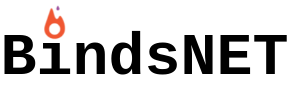

# Spiking Neural Networks in BindsNET
Official GitHub repository:

[https://github.com/BindsNET/bindsnet](https://github.com/BindsNET/bindsnet)

## Setup
Let's start with the setup of our development environment:

In [ ]:
# Install libraries
!pip install git+https://github.com/BindsNET/bindsnet.git

Let's import the necessary libraries to run this project:

In [ ]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time as t
import _pickle as cPickle

# PyTorch Imports
import torch
from torchvision import transforms

# BindsNET Import
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.models import DiehlAndCook2015
from bindsnet.network.monitors import Monitor
from bindsnet.utils import get_square_weights, get_square_assignments
from bindsnet.evaluation import all_activity, proportion_weighting, assign_labels
from bindsnet.analysis.plotting import plot_input, plot_spikes, plot_weights, plot_assignments, plot_performance, plot_voltages

Let's train a Spiking Neural Network on the train set of the MNIST dataset:

In [ ]:
# Let's assign some important variables: the parameters of the Spiking Neural Networks
# Seed
seed = 0

# Number of Neurons 
n_neurons = 100

# Number of Epochs
n_epochs = 1

# Number of Train Samples
n_train = 60000

# Number of Test Samples
n_test = 10000

# Number of Working Threads
n_workers = -1

# Excitatory Voltage
exc = 22.5

# Inhibitory Voltage
inh = 120

# Theta Parameter
theta_plus = 0.05

# Time for the Data Encoding using Poisson
time = 250

# Time Delta for the Data Encoding using Poisson
dt = 1.0

# Intensity for the Data Encoding using Poisson
intensity = 128

# Progress Prints Parameters
progress_interval = 10

# Update Interval Prints Parameters
update_interval = 250

# Variable to activate plots
plot = True

# Variable to allow access to the GPU
gpu = True



# Set up GPU(s)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu and torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
    if gpu:
        gpu = False


# Set up number of threads
torch.set_num_threads(os.cpu_count() - 1)
print(f"Running on: {device}")


# Determines number of threads to use
if n_workers == -1:
    n_workers = gpu * 4 * torch.cuda.device_count()


# For plot purposes
n_sqrt = int(np.ceil(np.sqrt(n_neurons)))


# Start intensity for data encoding
start_intensity = intensity


# Build Spiking Neural Network
network = DiehlAndCook2015(
    n_inpt=784,
    n_neurons=n_neurons,
    exc=exc,
    inh=inh,
    dt=dt,
    norm=78.4,
    theta_plus=theta_plus,
    inpt_shape=(1, 28, 28),
)


# Move Network to the GPU
if gpu:
    network.to("cuda")


# Load MNIST data
train_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("data", "MNIST"),
    download=True,
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)


# Record spikes during the simulation
spike_record = torch.zeros((update_interval, int(time / dt), n_neurons), device=device)


# Neuron assignments, spike proportions and fire rates
n_classes = 10
assignments = -torch.ones(n_neurons, device=device)
proportions = torch.zeros((n_neurons, n_classes), device=device)
rates = torch.zeros((n_neurons, n_classes), device=device)


# Sequence of accuracy estimates
accuracy = {"all": [], "proportion": []}


# Voltage recording for excitatory and inhibitory layers and add them to the Network
exc_voltage_monitor = Monitor(network.layers["Ae"], ["v"], time=int(time / dt), device=device)
inh_voltage_monitor = Monitor(network.layers["Ai"], ["v"], time=int(time / dt), device=device)
network.add_monitor(exc_voltage_monitor, name="exc_voltage")
network.add_monitor(inh_voltage_monitor, name="inh_voltage")


# Set up monitors for spikes and voltages
# Spikes
spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer], state_vars=["s"], time=int(time / dt), device=device)
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

# Voltages
voltages = {}
for layer in set(network.layers) - {"X"}:
    voltages[layer] = Monitor(network.layers[layer], state_vars=["v"], time=int(time / dt), device=device)
    network.add_monitor(voltages[layer], name="%s_voltages" % layer)


# Pre-assing starting variables
inpt_ims, inpt_axes = None, None
spike_ims, spike_axes = None, None
weights_im = None
assigns_im = None
perf_ax = None
voltage_axes, voltage_ims = None, None


# Train the network
print("\nBegin training.\n")

# Start time
start = t()

# Create an empty list for the label (the training is unsupervised)
labels = []


# Go through all epochs
for epoch in range(n_epochs):

    if epoch % progress_interval == 0:
        print("Progress: %d / %d (%.4f seconds)" % (epoch, n_epochs, t() - start))
        start = t()

    # Create a dataloader to iterate and batch data
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

    for step, batch in enumerate(tqdm(dataloader)):
        if step > n_train:
            break
        
        # Get next input sample.
        inputs = {"X": batch["encoded_image"].view(int(time / dt), 1, 1, 28, 28)}
        if gpu:
            inputs = {k: v.cuda() for k, v in inputs.items()}


        if step % update_interval == 0 and step > 0:
            # Convert the array of labels into a tensor
            label_tensor = torch.tensor(labels, device=device)

            # Get network predictions
            all_activity_pred = all_activity(spikes=spike_record, assignments=assignments, n_labels=n_classes)
            
            # Get neuron proportions
            proportion_pred = proportion_weighting(spikes=spike_record, assignments=assignments, proportions=proportions, n_labels=n_classes)

            # Compute network accuracy according to available classification strategies
            accuracy["all"].append(100 * torch.sum(label_tensor.long() == all_activity_pred).item() / len(label_tensor))
            accuracy["proportion"].append(100 * torch.sum(label_tensor.long() == proportion_pred).item() / len(label_tensor))

            # Status prints
            print("\nAll activity accuracy: %.2f (last), %.2f (average), %.2f (best)" % (accuracy["all"][-1], np.mean(accuracy["all"]), np.max(accuracy["all"])))
            print("Proportion weighting accuracy: %.2f (last), %.2f (average), %.2f (best)\n"% (accuracy["proportion"][-1], np.mean(accuracy["proportion"]), np.max(accuracy["proportion"])))


            # Assign labels to excitatory layer neurons
            assignments, proportions, rates = assign_labels(spikes=spike_record, labels=label_tensor, n_labels=n_classes, rates=rates)

            # Append the labels assigned in this batch
            labels = []


            # Save network into a .pt file
            network.save('network.pt')

            # Save the neuron assignments into a .pickle file
            with open('assignments.pickle', 'wb') as fp:
                cPickle.dump(assignments.detach().cpu().numpy(), fp, -1)


            # Save the neuron proportion into a .pickle file
            with open('proportions.pickle', 'wb') as fp:
                cPickle.dump(proportions.detach().cpu().numpy(), fp, -1)

            print('Model, assignments and proportions saved!')


        # Append the batch labels to this list
        labels.append(batch["label"])


        # Run the network on the inputs
        network.run(inputs=inputs, time=time, input_time_dim=1)


        # Get voltage recording
        exc_voltages = exc_voltage_monitor.get("v")
        inh_voltages = inh_voltage_monitor.get("v")


        # Add to spikes recording
        spike_record[step % update_interval] = spikes["Ae"].get("s").squeeze()


        # Optionally plot various simulation information.
        if plot:
            image = batch["image"].view(28, 28)
            inpt = inputs["X"].view(time, 784).sum(0).view(28, 28)
            input_exc_weights = network.connections[("X", "Ae")].w
            square_weights = get_square_weights(input_exc_weights.view(784, n_neurons), n_sqrt, 28)
            square_assignments = get_square_assignments(assignments, n_sqrt)
            spikes_ = {layer: spikes[layer].get("s") for layer in spikes}
            voltages = {"Ae": exc_voltages, "Ai": inh_voltages}
            inpt_axes, inpt_ims = plot_input(image, inpt, label=batch["label"], axes=inpt_axes, ims=inpt_ims)
            spike_ims, spike_axes = plot_spikes(spikes_, ims=spike_ims, axes=spike_axes)
            weights_im = plot_weights(square_weights, im=weights_im)
            assigns_im = plot_assignments(square_assignments, im=assigns_im)
            perf_ax = plot_performance(accuracy, x_scale=update_interval, ax=perf_ax)
            voltage_ims, voltage_axes = plot_voltages(voltages, ims=voltage_ims, axes=voltage_axes, plot_type="line")

            plt.pause(1e-8)


        # Reset state variables.
        network.reset_state_variables()  

        print("Progress: %d / %d (%.4f seconds)" % (epoch + 1, n_epochs, t() - start))


print("Training complete.\n")

Let's evaluate the performance of our network on the test set of the MNIST dataset:

In [ ]:
# Update this variable (for prints and plots purposes)
update_interval = n_test


# Build network again
network = DiehlAndCook2015(n_inpt=784, n_neurons=n_neurons, exc=exc, inh=inh, dt=dt, norm=78.4, theta_plus=theta_plus, inpt_shape=(1, 28, 28))

# Load network parameters
network = torch.load('network.pt')

# Move the network to the GPU
if gpu:
    network.to("cuda")


# Record spikes during the simulation
spike_record = torch.zeros((update_interval, int(time / dt), n_neurons), device=device)


# Load the neuron assignments and spike proportions (the network learned this during training)
n_classes = 10

# Assignments
with open('assignments.pickle', "rb") as f:
    assignments = cPickle.load(f)

assignments = torch.from_numpy(assignments).to(device)

# Proportions
with open('proportions.pickle', "rb") as f:
    proportions = cPickle.load(f)

proportions = torch.from_numpy(proportions).to(device)



# Voltage recording for excitatory and inhibitory layers
exc_voltage_monitor = Monitor(network.layers["Ae"], ["v"], time=int(time / dt), device=device)
inh_voltage_monitor = Monitor(network.layers["Ai"], ["v"], time=int(time / dt), device=device)
network.add_monitor(exc_voltage_monitor, name="exc_voltage")
network.add_monitor(inh_voltage_monitor, name="inh_voltage")

# Set up monitors for spikes and voltages
# Spikes
spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer], state_vars=["s"], time=int(time / dt), device=device)
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

# Voltages
voltages = {}
for layer in set(network.layers) - {"X"}:
    voltages[layer] = Monitor(network.layers[layer], state_vars=["v"], time=int(time / dt), device=device)
    network.add_monitor(voltages[layer], name="%s_voltages" % layer)


# Load MNIST test data
test_dataset = MNIST(PoissonEncoder(time=time, dt=dt), None, root=os.path.join("data", "MNIST"), download=True, train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]))

# Sequence of accuracy estimates.
accuracy = {"all": 0, "proportion": 0}

# Record spikes during the simulation
spike_record = torch.zeros((1, int(time / dt), n_neurons), device=device)

# Test the network
print("\nBegin testing\n")

# Put the network in test mode
network.train(mode=False)

# Start time
start = t()

# Get a fancy TQDM progress bar
pbar = tqdm(total=n_test)


# Create a list with the labels
r_labels = [i for i in range(n_classes)]

# Run the network on the data
for step, batch in enumerate(test_dataset):
    if step > n_test:
        break
    
    # Get next input sample.
    inputs = {"X": batch["encoded_image"].view(int(time / dt), 1, 1, 28, 28)}
    if gpu:
        inputs = {k: v.cuda() for k, v in inputs.items()}

    # Run the network on the input.
    network.run(inputs=inputs, time=time, input_time_dim=1)

    # Add to spikes recording.
    spike_record[0] = spikes["Ae"].get("s").squeeze()

    # Convert the array of labels into a tensor
    label_tensor = torch.tensor(batch["label"], device=device)

    # Get the label
    label = batch["label"]

    # Get network predictions
    all_activity_pred = all_activity(spikes=spike_record, assignments=assignments, n_labels=n_classes)
    proportion_pred = proportion_weighting(spikes=spike_record, assignments=assignments, proportions=proportions, n_labels=n_classes)

    # Compute network accuracy according to available classification strategies.
    accuracy["all"] += float(torch.sum(label_tensor.long() == all_activity_pred).item())
    accuracy["proportion"] += float(torch.sum(label_tensor.long() == proportion_pred).item())

    if step % 100 == 0:
        print("\nAll activity accuracy: %.2f" % (accuracy["all"] / (step + 1)))
        print("Proportion weighting accuracy: %.2f \n" % (accuracy["proportion"] / (step + 1)))


    # Reset state variables.
    network.reset_state_variables()  
    pbar.set_description_str("Test progress: ")
    pbar.update()

print("\nAll activity accuracy: %.2f" % (accuracy["all"] / n_test))
print("Proportion weighting accuracy: %.2f \n" % (accuracy["proportion"] / n_test))

print("Testing complete.\n")

## Challenge: can you pick up one (or more) dataset(s) and build the entire pipeline yourself?

In [ ]:
# Start your code here
# Some hints for stuff you will have to import:
# For Fashion-MNIST: from bindsnet.datasets import FashionMNIST
# For CIFAR-10: from bindsnet.datasets import CIFAR10

# More tutorials, exercises and readings:


1.   [BindsNET Documentation](https://bindsnet-docs.readthedocs.io)

2.   [BindsNET Examples](https://github.com/BindsNET/bindsnet/tree/master/examples)